<a href="https://colab.research.google.com/github/Gaurav1401/Deep-Learning/blob/main/FaceExpression_Recognition/FaceExpression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# !wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2021-12-30 21:20:21--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2021-12-30 21:20:21--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8b788304987818086f54363542.dl.dropboxusercontent.com/cd/0/inline/Bc3VlQwrvPWXYfWGcAAyatqA1o6bwgvvRsxfkW7ZaiWdF_oxCssuYoCpB44Zoue92lVXNS7IsAFPSDRpNVy50QAH78QbP81f3QR_u9f_tgfbKpQAHr227iFqTnMA4zzvJui3mlMti34bMfTYzX0HAD1f/file# [following]
--2021-12-30 21:20:21--  https://uc8b788304987818086f54363542.dl.dropboxusercontent.com/cd/0/inline/Bc3VlQwrvPWXYfWGcAAyatqA1o6bwgvvRsxfkW7ZaiWdF_oxCssuYoCpB44Zoue92lVXNS7IsAFPSDRpNVy50QAH78

In [8]:
# !unzip -q "/content/archive.zip"

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from pathlib import Path # To play with file paths
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings as wg
wg.filterwarnings("ignore")

In [10]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [11]:
list(train_path.glob("*/*"))[:5] # return image paths in form of Path Object

[PosixPath('/content/train/happy/Training_10240470.jpg'),
 PosixPath('/content/train/happy/Training_46719576.jpg'),
 PosixPath('/content/train/happy/Training_13542808.jpg'),
 PosixPath('/content/train/happy/Training_26049115.jpg'),
 PosixPath('/content/train/happy/Training_23419201.jpg')]

In [12]:
str(list(train_path.glob("*/*"))[0]) # Each object need to be converted to string

'/content/train/happy/Training_10240470.jpg'

In [13]:
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x: str(x), train_image_paths)) 
# Getting all paths in the form of string using map function

train_image_paths[:5]

['/content/train/happy/Training_10240470.jpg',
 '/content/train/happy/Training_46719576.jpg',
 '/content/train/happy/Training_13542808.jpg',
 '/content/train/happy/Training_26049115.jpg',
 '/content/train/happy/Training_23419201.jpg']

In [14]:
'/content/train/neutral/Training_29136162.jpg'.split("/")[-2] # Getting image label from file path

'neutral'

In [15]:
# Getting image labels for all images using map
train_labels = list(map(lambda x: x.split("/")[-2], train_image_paths)) 

In [16]:
len(train_labels), len(train_image_paths)

(28709, 28709)

In [17]:
# Convert all the string labels into numbers
le = LabelEncoder()
train_image_labels = le.fit_transform(train_labels)

train_image_labels[:5]

array([3, 3, 3, 3, 3])

In [18]:
# The numeric labels should be treated as categorical instead of continuous values
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

In [19]:
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths,
                                                                    train_image_labels,
                                                                    test_size = 0.2)

In [20]:
len(train_paths), len(val_paths)

(22967, 5742)

In [21]:
image = tf.io.read_file(train_paths[10])
image = tf.image.decode_jpeg(image, channels = 3)

In [22]:
np.max(tf.image.decode_jpeg(tf.io.read_file(train_paths[100])))

255

In [23]:
image.shape

TensorShape([48, 48, 3])

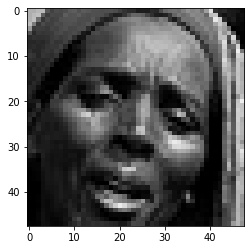

In [24]:
plt.imshow(image)

In [25]:
np.max(image), np.min(image) # Need to resize and rescale the image

(238, 0)

**Refer to [this](https://www.tensorflow.org/api_docs/python/tf/io/read_file) link to know more about this function**

In [26]:
# Function to load each image in form of tensorflow object
def load_tensor_image(img_path, label):
    image = tf.io.read_file(img_path)
    # decoded_img = tf.image.rgb_to_grayscale(tf.image.decode_png(image))
    decoded_img = tf.image.decode_jpeg(image, channels = 3)
    # final_img = tf.image.resize(decoded_img, [512, 512], method = "nearest")
    
    return decoded_img, label

**Data Augmentation using tf.keras.sequential:- [Click here](https://www.tensorflow.org/tutorials/images/data_augmentation)**

In [27]:
IMG_SIZE = 96


resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
def get_dataset(images, labels, train = False):
    image_paths = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    
    dataset = dataset.map(lambda image, label: load_tensor_image(image, label))
    dataset = dataset.map(lambda image, label: (resize_and_rescale(image), label), 
              num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    
    if train:
      dataset = dataset.map(lambda image, label: (data_augmentation(image), label), 
                num_parallel_calls=AUTOTUNE)
      
    dataset = dataset.repeat()
    return dataset

In [29]:
train_dataset = get_dataset(train_paths, train_labels, train = True)

In [30]:
image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


In [31]:
val_dataset = get_dataset(train_paths, train_labels) # No Augmentation

In [32]:
image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


## **Using Transfer Learning For predictions**

In [33]:
backbone = tf.keras.applications.efficientnet.EfficientNetB2(
           include_top=False, weights='imagenet',
           input_shape=(96,96,3)
           )

31801344/31790344 [==============================] - 0s 0us/step


In [34]:
model = tf.keras.Sequential([
                backbone,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(128, activation = "relu"),
                tf.keras.layers.Dense(7, activation = "softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non-trainable params: 67,575
_________________________________________________________________


In [35]:
model.layers

In [36]:
model.layers[0].trainable = False

In [37]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose = 1, save_best_only = True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience = 3)

In [38]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= "categorical_crossentropy",
              metrics=['accuracy'])

In [39]:
history = model.fit(train_dataset,
                    steps_per_epoch = len(train_image_paths)//BATCH_SIZE,
                    epochs = 10,
                    callbacks = [checkpoint, early_stop],
                    validation_data = val_dataset,
                    validation_steps = len(val_paths)//BATCH_SIZE)

Epoch 1/10
897/897 [==============================] - ETA: 0s - loss: 1.8195 - accuracy: 0.2469
Epoch 00001: val_loss improved from inf to 1.83174, saving model to best_weights.h5
897/897 [==============================] - 93s 84ms/step - loss: 1.8195 - accuracy: 0.2469 - val_loss: 1.8317 - val_accuracy: 0.2497
Epoch 2/10
897/897 [==============================] - ETA: 0s - loss: 1.8150 - accuracy: 0.2508
Epoch 00002: val_loss improved from 1.83174 to 1.82773, saving model to best_weights.h5
897/897 [==============================] - 80s 89ms/step - loss: 1.8150 - accuracy: 0.2508 - val_loss: 1.8277 - val_accuracy: 0.2523
Epoch 3/10
897/897 [==============================] - ETA: 0s - loss: 1.8139 - accuracy: 0.2508
Epoch 00003: val_loss improved from 1.82773 to 1.81524, saving model to best_weights.h5
897/897 [==============================] - 76s 85ms/step - loss: 1.8139 - accuracy: 0.2508 - val_loss: 1.8152 - val_accuracy: 0.2521
Epoch 4/10
897/897 [==============================] -